/Users/b295319/anaconda3/lib/python3.6/site-packages/kwant/linalg/lll.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs = np.linalg.lstsq(vecs_orig.T, vecs.T)[0]
/Users/b295319/anaconda3/lib/python3.6/site-packages/kwant/linalg/lll.py:144: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  center_coords = np.array(np.round(np.linalg.lstsq(basis.T, vec)[0]), int)
/Users/b295319/anaconda3/lib/python3.6/site-packages/kwant/linalg/lll.py:144: FutureWarning: `rcond` parameter will change to the default of machine preci

Total number of sites: 260


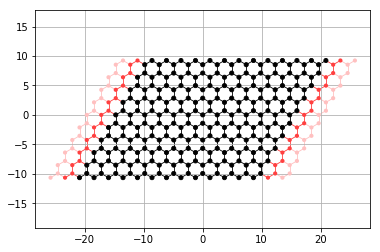

In [99]:
from math import pi, sqrt, tanh
import kwant
from matplotlib import pyplot
import numpy as np
from functools import partial
import copy
%matplotlib inline

# function to rotate 2D vectors
def rot(vec, theta):
    rot_mat = np.array([ [np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)] ])
    return rot_mat.dot(vec)

# function to find a vector orthogonal to the passed vector
def orthogVecSlope(vec):
    A = np.array([[vec[0], vec[1]], [-vec[1], vec[0]]])
    trans_vec = np.linalg.solve(A, np.array([0., 1.]))
    if trans_vec[0] == 0.:
        a = 0.
    else:
        a = trans_vec[1] / trans_vec[0]
    return a

# lattice constant
a = 1.42
# hopping energy
t = 2.7
# on-site energy of 0 gives singular matrix
on_site = 0.0
# length of hexagon
l = 10.0
# ratio to define x-length of hexagon
ratio = sqrt(3) / 2
lx = l * ratio
# slope for defining hexagon
m = np.sin(np.pi / 6) / np.cos(np.pi / 6)



# if we want conducting (zigzag) leads or not, else semi-conducting (armchair) leads
conducting = True

if conducting:
    # set lattice vectors and basis 
    v1 = np.array((a * sqrt(3) / 2., 3 * a / 2))
    v2 = np.array((-a * sqrt(3) / 2., 3 * a / 2))
    graphene = kwant.lattice.general([v1, v2], [(0, 0), (0, -a) ], norbs=1 )
else:
    v1 = np.array((3 * a / 2, a * sqrt(3) / 2.))
    v2 = np.array((3 * a / 2, -a * sqrt(3) / 2.))
    graphene = kwant.lattice.general([v1, v2], [(0, 0), (-a, 0) ], norbs=1 )
    
def make_system(spin=1/2):
    
    # hexagon shape
    def hexagon(pos):
        x, y = pos
        y += 0.75
        return -lx <= x <= lx and -l <= x * m + y <= l and -l <= -x * m  + y  <= l

    # rectangular shape
    def rectangle(coord, angle=0., xcoords=None, ycoords=None, shift=[0., 0.]):
        x, y = coord
        new_val = rot(coord, -angle)
        return xcoords[0] <= new_val[0] - shift[0] <= xcoords[1] and ycoords[0] <= new_val[1] - shift[1] <= ycoords[1]
    
    def phase(site1,site2, phi):
        # kwant implementation for rectangular lattices
        p1 = site1.pos
        n, m = site1.tag
        q, p = site2.tag
        p2 = site2.pos
        B = -2 * phi / 3 / np.sqrt(3) / 1.42**2
        return -t * np.exp(1j * np.pi * (p2[0] - p1[0]) * (p2[1] + p1[1]) * B)
#         if conducting:
#             z = 1
#         else:
#             z = -1
        
#         if m == p and n == q:
#             return -t * np.exp(2j * np.pi * phi * n * (1 - z) / 2)
#         elif m == p - 1 and n == q - (1 - z) / 2:
#             return -t * np.exp(-2j * np.pi * phi * n)
#         elif m == p + 1 and n == q - (1 - z) / 2:
#             return -t * np.exp(-2j * np.pi * phi * n)
#         elif m == p and n == q - z:
#             return -t * np.exp(2j * np.pi * phi * n * (z - 1) / 2)
#         elif m == p and n == q + z:
#             return -t * np.exp(2j * np.pi * phi * n * (z - 1) / 2)
#         else:
#             return -t
    
    def onSite(site, phi):
        B = -2 * phi / 3 / np.sqrt(3) / 1.42**2
        return spin * B

        
    # construct the nanojunction
    ############################
    syst = kwant.Builder()
    if conducting:
        shape = lambda pos:  rectangle(pos, angle=0, xcoords=[-l, l], ycoords=[-l, l], shift=[0., -0.75])
    else:
        shape = lambda pos:  rectangle(pos, angle=0, xcoords=[-2*l, 2*l], ycoords=[-l / 2, l / 2], shift=[0., -0.75])

    # set the on-site energies
    syst[graphene.shape(shape , (0, 0))] = onSite
    # set the hopping energies
    syst[graphene.neighbors()] = phase
    # remove lone orbitals
    syst.eradicate_dangling()
    ############################
    
    # add the lead on the left hand side
    ####################################
    if conducting:
        sym = kwant.TranslationalSymmetry(graphene.vec((-1, 1)))
        lead = kwant.Builder(sym)
        a = orthogVecSlope(graphene.vec((-1, 1)))
        lead[graphene.shape(lambda pos: -l < (pos[1] + 0.75)  + pos[0] * a < l , (0,0))] = onSite
        lead[graphene.neighbors()] = phase
        lead.eradicate_dangling()
        syst.attach_lead(lead)
    else:
        sym = kwant.TranslationalSymmetry(graphene.vec((-1, -1)))
        lead = kwant.Builder(sym)
        a = orthogVecSlope(graphene.vec((-1,-1)))
        lead[graphene.shape(lambda pos: -l/2  < (pos[1] + 0.75) + pos[0] * a < l / 2, (0,0))] = onSite
        lead[graphene.neighbors()] = phase
        lead.eradicate_dangling()
        syst.attach_lead(lead)
    ####################################
    
    syst.attach_lead(lead.reversed())
    return syst

syst_up = make_system(spin=1/2)
syst_down = make_system(spin=-1/2)
print('Total number of sites:', len(syst_up.sites()))

# To highlight the two sublattices of graphene, we plot one with
# a filled, and the other one with an open circle:
def family_colors(site):
    return 0 if site.family == a else 1

# Then, plot the system with leads.
kwant.plot(syst_up, site_lw=0.1, lead_site_lw=0, site_color=family_colors, colorbar=False, show=False)
pyplot.axis('equal')
pyplot.grid(True)
pyplot.show()

# Finalize the system.
syst_up = syst_up.finalized()
syst_down = syst_down.finalized()

In [91]:
phi = 10 / 701
momenta = np.linspace(-np.pi, np.pi, 256)
# bands0 = kwant.physics.Bands(syst.leads[0], params={'phi': 0 / 65875.})
# energies0 = [bands0(k) for k in momenta]
bands_up = kwant.physics.Bands(syst_up.leads[0], params={'phi': phi})
bands_down = kwant.physics.Bands(syst_down.leads[0], params={'phi': phi})

energies_up = [bands_up(k) for k in momenta]
energies_down = [bands_down(k) for k in momenta]

# pyplot.plot(momenta, np.divide(energies0, t), 'r--', momenta, np.divide(energies1, t), 'b-')

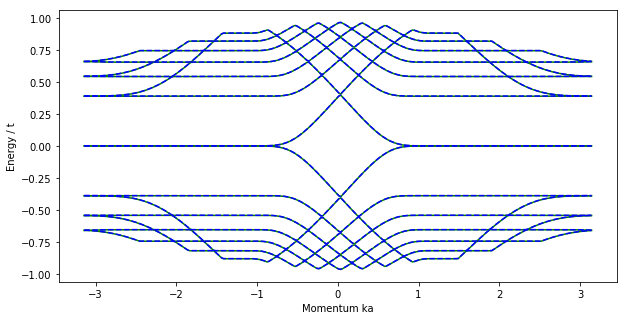

In [92]:
fig, axes = pyplot.subplots(1,1, figsize=(10,5), sharey='row')
nbands = np.array(energies_up).shape[1]
pyplot.plot(momenta , np.array(energies_up)[:, nbands // 2 - 7: nbands // 2 + 7] / t, 'g-', momenta , np.array(energies_down)[:, nbands // 2 - 7: nbands // 2 + 7] / t, 'b--')
pyplot.ylabel('Energy / t')
pyplot.xlabel('Momentum ka')
pyplot.show()

In [93]:
# calculate the conductance using the smatrix function of kwant
def conductance(syst, energies, lead_start=0, lead_end=1):
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy, params={'phi': phi})
        data.append(smatrix.transmission(lead_start, lead_end))
    return data
    
def DOS(syst):
    energies, doss = [], []
    for e in np.linspace(-10.0, 10.0, 256):
        # sometimes the ldos function returns an error for a certain value of energy
        # -- we therefore must use a try-except statement
        try:
            dos = kwant.ldos(syst, e, params={'phi': phi})
            energies.append(e)
            # integrate the ldos over all space
            doss.append(np.sum(dos))
        except:
            pass
    return energies, doss

# calculate the two conductances for the two leads
e = np.linspace(-10,10,256)
cond_up = conductance(syst_up, energies=e)
cond_down = conductance(syst_down, energies=e)
e_up, dos_up = DOS(syst_up)
e_down, dos_down = DOS(syst_down)


Total number of states: 0.0


Text(0.5,0,'Density of states [Arbitrary units]')

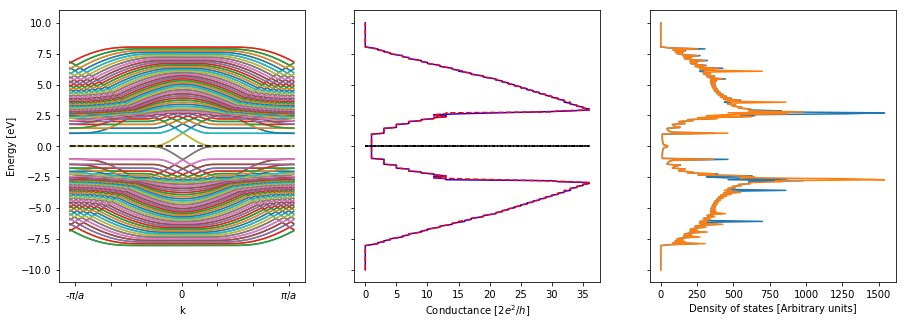

In [94]:
# plot the bandstructure, conductances, and DOS
fig, axes = pyplot.subplots(1,3, figsize=(15,5), sharey='row')
kwant.plotter.bands(syst_up.leads[0], momenta=np.linspace(-np.pi,  np.pi, 256), show=False, ax=axes[0], params={'phi': phi})
kwant.plotter.bands(syst_down.leads[0], momenta=np.linspace(-np.pi,  np.pi, 256), show=False, ax=axes[0], params={'phi': phi})


axes[1].plot(cond_up, e, 'b-')
axes[1].plot(cond_down, e, 'r--')

axes[2].plot(dos_up, e_up)
axes[2].plot(dos_down, e_down)

e_fermi = np.ones(256) * on_site
axes[0].plot(np.linspace(-np.pi,  np.pi, 256), e_fermi, 'k--')
axes[1].plot(cond_up, e_fermi, 'k--')
axes[2].plot(doss, np.ones_like(energies) * on_site, 'k--')

print('Total number of states:', np.sum(doss))

axes[0].set_ylim((np.min(e_up) -1, np.max(e_up) + 1))
axes[1].set_ylim((np.min(e_up) -1, np.max(e_up) + 1))
axes[2].set_ylim((np.min(e_up) -1, np.max(e_up) + 1))
axes[0].set_xlabel('k')
axes[0].set_ylabel('Energy [eV]')
pyplot.sca(axes[0])
pyplot.xticks(range(-3,4), ['-$\pi / a$', '', '', 0, '', '', '$\pi / a$'])

axes[1].set_xlabel('Conductance [$2e^2 / h$]')
axes[2].set_xlabel('Density of states [Arbitrary units]')

Text(0,0.5,'dI / dV [$2e^2 h^{-1} eV^{-1}$]')

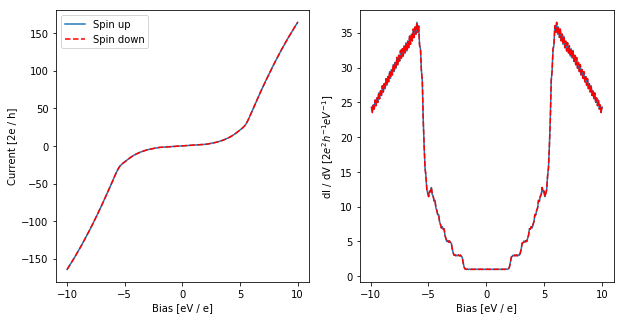

In [95]:
# define the temperature multiplied by the Boltzmann constant
kB_T = t / 100.
# the Fermi-Dirac distribution
def fermi(E, mu):
    return 1. / (np.exp((E - mu) / (kB_T)) + 1.)

# make the function vectorized
vec_fermi = np.vectorize(fermi)

# range of bias values
bias = np.linspace(-10.0, 10.0, 256)
db = bias[1] - bias[0]
# collect the current values in lists 
I_up = []
dI_up = []
I_down = []
dI_down = []
# loop over the bias values
for i, val in enumerate(bias):
    # make the chemical potential differences symmetric about the bias
    mu_left = val / 2.0 + on_site 
    mu_right = -val / 2.0 + on_site
    
    # difference in the Fermi-Dirac functions
    diff = vec_fermi(e, mu_left) - vec_fermi(e, mu_right)
    
    # multiply the conductances by the difference and integrate over the energy
    current_up = (e[1] - e[0]) * np.sum(cond_up * diff)
    current_down = (e[1] - e[0]) * np.sum(cond_down * diff)


    # append value to list
    I_up.append(current_up)
    I_down.append(current_down)


    if i > 0:
        dI_up.append((current_up - I_up[i - 1]) / db)
        dI_down.append((current_down - I_down[i - 1]) / db)

# plot the currents
fig, axes = pyplot.subplots(1, 2, figsize=(10,5))
axes[0].plot(bias, I_up, bias, I_down, 'r--')
axes[0].legend(['Spin up', 'Spin down'])
axes[0].set_xlabel('Bias [eV / e]')
axes[0].set_ylabel('Current [2e / h]')
# plot the differential dI/dV
axes[1].plot(bias[1:], dI_up, bias[1:], dI_down, 'r--')
axes[1].set_xlabel('Bias [eV / e]')
axes[1].set_ylabel('dI / dV [$2e^2 h^{-1} eV^{-1}$]')